## Generating images using a Generative Adversarial Network (GAN)

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [2]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [3]:
# Input shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100


optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


Discriminator model tries to guess if an image belongs to a training dataset

In [4]:
# Build and compile the discriminator

discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

img = Input(shape=img_shape)
validity = discriminator(img)

discriminator = Model(img, validity)
discriminator.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Generator model tries to generate an image to fool the discriminator

In [5]:
# Build the generator

generator = Sequential()

generator.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(channels, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))


noise = Input(shape=(latent_dim,))
img = generator(noise)
generator = Model(noise, img)

In [6]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [21]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

epochs = 4000
batch_size = 32
save_interval = 500

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs+1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    
    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        save_imgs(epoch)

0 [D loss: 0.711393, acc.: 46.88%] [G loss: 0.794711]
500 [D loss: 0.552354, acc.: 70.31%] [G loss: 1.115951]
1000 [D loss: 0.704400, acc.: 57.81%] [G loss: 0.943878]
1500 [D loss: 0.545730, acc.: 70.31%] [G loss: 1.084132]
2000 [D loss: 0.679213, acc.: 64.06%] [G loss: 0.942177]
2500 [D loss: 0.630869, acc.: 59.38%] [G loss: 1.014840]
3000 [D loss: 0.840860, acc.: 42.19%] [G loss: 0.749126]
3500 [D loss: 0.626780, acc.: 68.75%] [G loss: 0.964709]


In [22]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")
combined.save("combined.h5")

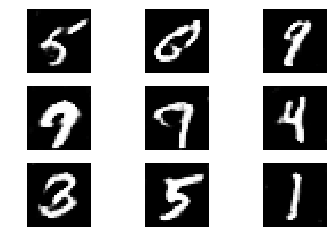

In [9]:
%matplotlib inline
generator.load_weights("generator.h5")
r, c = 3, 3
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
